# Python code for classification of Toxic comments

### Checking the Python Version used in this Research

In [8]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]'

### Importing Necessary Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

###  Reading the training file

In [10]:
#Read the csv file into dataframe df
df = pd.read_csv("toxic/train.csv", encoding = 'utf8')
print(df.shape)

(159571, 8)


### Profiling of Data

In [4]:
import pandas_profiling

In [5]:
pandas_profiling.ProfileReport(df)

###  Randomly selecting records from dataset for further processing

In [11]:
import random
dataset_sub = df.sample(random.randint(11000,15000), random_state=1)

In [12]:
print(dataset_sub.shape)

(13728, 8)


In [14]:
dataset_sub.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0


### List of various fields used in the dataset

In [15]:
print(dataset_sub.dtypes)

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


#### It is clear that sufficient large dataset has been used in this research and it has '159566' comment lines. It requires systems with high processing power. 

#### It was also noticed that executing train test-split on a large pre - processed dataframe often caused the machine to run out of storage.

#### To overcome such issue, re-indexing had been done using 'dataset_sub.reindex' which will do shuffling of all the indices on first place. It will help in giving the positive results while splitting the dataset in later part.

### The line below allows the indices to scramble to prevent using train test split later.

In [16]:
dataset_sub = dataset_sub.reindex(np.random.permutation(dataset_sub.index))

### Separating the comment field from dataset

In [18]:
comment = dataset_sub['comment_text']
print(comment.head())

84361    "==Kolyma==\nI came across the Kolyma article ...
76475    Why bother with signing my name when you tempo...
15729    Bob Knight (basketball)\nI moved the article b...
37399    Maiden tour in Romania ? \n\nI don't remember,...
35284    Okay, sounds good.  Find out from BCGNIS & the...
Name: comment_text, dtype: object


In [19]:
comment = comment.to_numpy()

### Separating all labels from dataset

In [20]:
label = dataset_sub[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]
print(label.head())
label = label.to_numpy()

       toxic  severe_toxic  obscene  threat  insult  identity_hate
84361      0             0        0       0       0              0
76475      0             0        0       0       0              0
15729      0             0        0       0       0              0
37399      0             0        0       0       0              0
35284      0             0        0       0       0              0


In [78]:
label.shape

(13752, 6)

### Counting the frequency of appearance of the labels

#### Freq1 :-   Number of comments with atleast one label

#### Freq2 :- Number of comments with more than one label 

In [21]:
freq1,freq2 = 0,0
for i in range(label.shape[0]):
    freq = np.count_nonzero(label[i])
    if freq :
        freq1 = freq1+1
    if freq>1 :
        freq2 = freq2+1
print(freq1)
print(freq2)

1451
873


### Data Visualisations

#### Analysis of comment no. with lengths varying between 0 and 1200 

average length of comment: 393.334


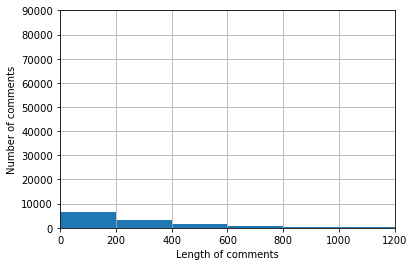

In [20]:

x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

### Analysis of comments labeled as insult,toxic,sever_toxic etc. on the basis of length of comment

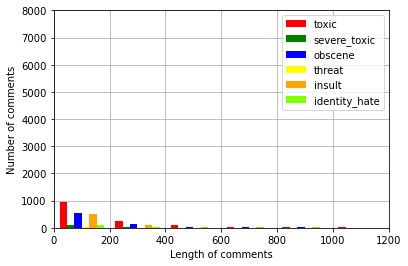

In [89]:
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['red','green','blue','yellow','orange','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 8000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

### Elimination of Lengthy comments

#### In the dataset, some very long comments could be seen.This poses a threat, such as adding too many words to the training dataset.

#### This can contribute to higher training time and lower accuracy of model. 

#### This will result in a threshold of 400 characters and therefore only comments of less than 400 characters will be utilized.


In [82]:
comments = []
labels = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])
        labels.append(label[ix])

In [83]:
labels = np.asarray(labels)

In [84]:
print(len(comments))

9935


# Preprocessing

#### The following measures included preprocessing,Those are carried out in a somewhat different ways:

#### 1) Removal of punctuations and other special features from comments.

#### 2)  Removal of Stop words

#### 3) Stemming and Lemmatising

#### 4) Divide the comments into separate words

#### 5) Implementation of count vectorizer for feature collection

#### 6) Divide the data in training and testing


###  Prepare a list of all the punctuations to delete.

####  The string library includes punctuation characters.All numbers are imported and added to this list.A field with comment text containing strings like 'not, did' etc which include apostrophe (') characters, is clearly visible in the dataset.In the notation of escape sequence, the 'represented character' in the punctuation string is replaced by a blank character to avoid converting these words into wont / didnt.  


In [85]:
import string
print(string.punctuation)
punctuation_edit = string.punctuation.replace('\'','') +"0123456789"
print (punctuation_edit)
outtab = "                                         "
trantab = str.maketrans(punctuation_edit, outtab)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789


####  Here, maketrans() returns a translation table ,which maps each character to the same located position in the outtab string in a point edit, that is to say it supersedes all characters in the delete list with space because outtab contains the space string. 

### Update the stop words list

####  Stop words are commonly used in both written and spoken correspondence and thus have no negative or constructive effect on our argument. 

####  If existing or created in one letter because of any pre-processing step there is no useful meaning, and it is therefore possible to remove them directly.Therefore, the lists of specifically imported stop words should be added with letters from b to z.


In [86]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
stop_words = stopwords.words('english')

In [87]:
# from stop_words import get_stop_words
# stop_words = get_stopwords('english')
stop_words.append('')

for x in range(ord('b'), ord('z')+1):
    stop_words.append(chr(x))

In [88]:
print (stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Stemming and Lemmatizing

#### Stemming is the process by which inflected / derived words are converted to their word stem or root form.
#### Some related words of origin have been modified into the same word.This contributes to better accuracy of the training process.

#### Lemmatizing is to combine the inflected forms of a word into a single object, so that they can be analyzed. It is close to stemming from its research but different, since the desired aspect of the vocabulary and meaning of a word in a sentence relies on the right definition.A greater context, including adjacent phrases or a whole book, that surrounds the word.

#### In this reason the wordnet library in nltk is used.Stemmer and Lemmatizer from Nltk are also imported.


In [89]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [90]:
#create objects for stemmer and lemmatizer
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()
#download words from wordnet library
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Pushpit
[nltk_data]     Gautam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### looping through all the comments

 > Removal of Punctuation
 > Operation of stem and lemmatizer
 > Divide words into space
 > Recombining terms for future care

In [92]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

### Apply the Count Vectorizer

#### Eventually statements can be transformed into a token count matrix, which implies the number of times it happens.

In [93]:
#Import the library required
from sklearn.feature_extraction.text import CountVectorizer

#Create an object that supplies our custom stop words
count_vector = CountVectorizer(stop_words=stop_words)
#Fitting it to converts comments into bag of words format
tf = count_vector.fit_transform(comments).toarray()

In [94]:
# print(count_vector.get_feature_names())
print(tf.shape)

(9935, 15940)


####  From the result, it can be implied that after pre-processing all the words are in the form of list. 

### Splitting dataset into training and testing

> The system was running out of memory with train test split so to overcome this issue at the beginning, all of the indices were jumbled.

#####  The shuffling function described here is structured to assign the first 2/3 value to the training and the remaining 1/3 to the test collection.

In [95]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels,3)

print(X_test.shape)
print(X_train.shape)

(3311, 15940)
(6624, 15940)


### Implementation of classifiers 

#### Below defining the hamming loss, accuracy and log accuracy that will use further for measuring the performance. 

In [96]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

### Begin with the First Model 

### 1. Binary Relevance (BR) Method with Multinomial Naïve Bayes 

In [98]:
from sklearn.naive_bayes import MultinomialNB

In [99]:
# Clf shall be a list of all 6 labels
# The training data and the accompanying classifier are appropriate for each classifier
clf = []
for ix in range(6):
    clf.append(MultinomialNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [100]:
# Predict list contains the predictions, which are translated to the correct form later
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

predict = np.asarray(np.transpose(predict))
print(predict.shape)

(3311, 6)


In [101]:
# Compute results
evaluate_score(Y_test,predict)

Hamming_loss : 3.996778415383066
Accuracy : 86.71096345514951
Log_loss : 2.2276501415907135


### 2. Binary Relevance Method with SVM classifier

In [102]:
from skmultilearn.problem_transform import BinaryRelevance

In [103]:
#create and fit classifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
classifier2 = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier2.fit(X_train, Y_train)

C:\Users\Pushpit Gautam\Anaconda3\envs\AI2_course\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Pushpit Gautam\Anaconda3\envs\AI2_course\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Pushpit Gautam\Anaconda3\envs\AI2_course\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\U

BinaryRelevance(classifier=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
        require_dense=[False, True])

In [107]:
#predictions
predictions2 = classifier2.predict(X_test)

In [109]:
#calculate scores
evaluate_score(Y_test,predictions2)

Hamming_loss : 4.661230242625591
Accuracy : 87.46602234974328
Log_loss : 0.5011082055285953


### 3.  Binary Relevance (BR) Method with Multinomial Naïve Bayes classifier

In [110]:
#create and fit classifier
classifier3 = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
classifier3.fit(X_train, Y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        require_dense=[False, True])

In [111]:
#predictions
predictions3 = classifier3.predict(X_test)

In [114]:
#calculate scores
evaluate_score(Y_test,predictions3)

Hamming_loss : 3.996778415383066
Accuracy : 86.71096345514951
Log_loss : 2.2276501415907135


### 4. Gaussian Naïve Bayes classifier using Binary relevance method

In [44]:
from sklearn.naive_bayes import GaussianNB
#create and fit classifiers
clf = []
for ix in range(6):
    clf.append(GaussianNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [45]:
#predictions
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

In [46]:
#calculate scores
predict = np.asarray(np.transpose(predict))
evaluate_score(Y_test,predict)

Hamming_loss : 9.95853152823515
Accuracy : 71.6062934504208
Log_loss : 1.638955572172705


### 5. Multinomial Naïve Bayes classifier using Classifier chain method

In [88]:
#create and fit classifier
from skmultilearn.problem_transform import ClassifierChain
classifier = ClassifierChain(MultinomialNB())
classifier.fit(X_train, Y_train)

ClassifierChain(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        order=None, require_dense=[True, True])

In [48]:
#predictions
predictions = classifier.predict(X_test)

In [49]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 4.4944505427491155
Accuracy : 86.53494328576656
Log_loss : 1.4922586026961304


### 6. Multinomial Naïve Bayes classifier using Label Powerset method 

In [50]:
#create and fit classifier
from skmultilearn.problem_transform import LabelPowerset
classifier = LabelPowerset(MultinomialNB())
classifier.fit(X_train, Y_train)

LabelPowerset(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       require_dense=[True, True])

In [51]:
#predictions
predictions = classifier.predict(X_test)

In [52]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 3.67117941212343
Accuracy : 87.63263812660081
Log_loss : 1.1206619396018391


# Enhanced Algorithms

### 7. Multi Label K-Nearest Neighbours

#### This is K Nearest Neighbours' adapted multi-label version. It is being implemented in the multi-learn library.

In [53]:
#create and fit classifier
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=2)
classifier.fit(X_train, Y_train)

MLkNN(ignore_first_neighbours=0, k=2, s=1.0)

In [54]:
#predictions
predictions = classifier.predict(X_test)

In [55]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 5.836077570435419
Accuracy : 81.4123673618734
Log_loss : 1.1639493986747649


### 8. Back Propagation for Multi-label Neural Networks 

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

Using TensorFlow backend.
C:\Users\Pushpit Gautam\Anaconda3\envs\AI2_course\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Pushpit Gautam\Anaconda3\envs\AI2_course\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Pushpit Gautam\Anaconda3\envs\AI2_course\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Us

In [57]:
#define model architecture
model = Sequential()
model.add(Dense(4, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 57088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 30        
Total params: 57,118
Trainable params: 57,118
Non-trainable params: 0
_________________________________________________________________


In [58]:
#compile model with all parameters set
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
#Fit using check pointer
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.myneural.h5py', 
                               verbose=1, save_best_only=True)
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5467/5467 [==============================] - 2s 423us/step - loss: 0.4750 - acc: 0.5016
Epoch 2/10
5467/5467 [==============================] - 2s 279us/step - loss: 0.4387 - acc: 0.7880
Epoch 3/10
5467/5467 [==============================] - 2s 275us/step - loss: 0.4103 - acc: 0.9945
Epoch 4/10
5467/5467 [==============================] - 2s 275us/step - loss: 0.3940 - acc: 0.9951
Epoch 5/10
5467/5467 [==============================] - 2s 275us/step - loss: 0.3872 - acc: 0.9951
Epoch 6/10
5467/5467 [==============================] - 2s 275us/step - loss: 0.3802 - acc: 0.9951
Epoch 7/10
5467/5467 [==============================] - 2s 275us/step - loss: 0.3740 - acc: 0.9951
Epoch 8/10
5467/5467 [==============================] - 2s 275us/step - loss: 0.3738 - acc: 0.9951
Epoch 9/10
5467/5467 [==============================] - 2s 275us/step - loss: 0.3698 - acc: 0.9951
Epoch 10/10
5467/5467 [==============================] - 2s 2

In [60]:
#predictions
predict = model.predict(X_test)

In [61]:
print(predict[0])

[0.43222672 0.05934711 0.20842811 0.03695919 0.20867747 0.05436129]


#### The results of the model are in the form of probabilities and Hamming loss and log loss deon't work on decimal values. Hence, it is very essential to convert the probabilites in the form 0 and 1.

#### Moreover, log losses can directly calculate without changing the values.

In [62]:
#calculate score
loss = log_loss(Y_test,predict)
print("Log_loss : {}".format(loss))
predict = np.round(predict)
loss = hamming_loss(Y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))


Log_loss : 0.35422937790094783
Hamming_loss : 12.92230759848762
Accuracy : 35.38236370289059


### Improved Back Propagation for Multi-label Neural Networks

In [63]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers

#define parameters for using in param grid
nodes = [16, 32, 64] # A hidden layer's number of nodes.
lrs = [0.001, 0.002, 0.003] # learning rate, default = 0.001
epochs = [10,20,30]
batch_size = 64

In [64]:
def create_model(nodes=10,lr=0.001):
    model = Sequential()
    model.add(Dense(nodes, activation='relu', input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))
    opt = optimizers.RMSprop(lr=lr)
    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

In [65]:
#start fitting process
param_grid = dict(epochs=epochs,nodes=nodes, lr=lrs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,refit=True,verbose=2)
grid_result = grid.fit(X_train, Y_train)

C:\Users\Pushpit Gautam\Anaconda3\envs\AI2_course\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] epochs=10, lr=0.001, nodes=16 ...................................
Epoch 1/10
3644/3644 [==============================] - 2s 447us/step - loss: 0.4541 - acc: 0.5467
Epoch 2/10
3644/3644 [==============================] - 1s 336us/step - loss: 0.4044 - acc: 0.9517
Epoch 3/10
3644/3644 [==============================] - 1s 335us/step - loss: 0.3804 - acc: 0.9918
Epoch 4/10
3644/3644 [==============================] - 1s 334us/step - loss: 0.3683 - acc: 0.9896
Epoch 5/10
3644/3644 [==============================] - 1s 336us/step - loss: 0.3626 - acc: 0.9819
Epoch 6/10
3644/3644 [==============================] - 1s 334us/step - loss: 0.3556 - acc: 0.9819
Epoch 7/10
3644/3644 [==============================] - 1s 335us/step - loss: 0.3509 - acc: 0.9753
Epoch 8/10
3644/3644 [==============================] - 1s 336us/step - loss: 0.3448 - acc: 0.9698
Epoch 9/10
3644/3644 [==============================] - 1s 336us/step - loss

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s


Epoch 1/10
3645/3645 [==============================] - 2s 451us/step - loss: 0.4636 - acc: 0.9141 1s - loss: 0.4598
Epoch 2/10
3645/3645 [==============================] - 1s 346us/step - loss: 0.4117 - acc: 0.9879
Epoch 3/10
3645/3645 [==============================] - 1s 337us/step - loss: 0.3895 - acc: 0.9846
Epoch 4/10
3645/3645 [==============================] - 1s 334us/step - loss: 0.3745 - acc: 0.9767
Epoch 5/10
3645/3645 [==============================] - 1s 347us/step - loss: 0.3693 - acc: 0.9789 1s - loss:
Epoch 6/10
3645/3645 [==============================] - 1s 337us/step - loss: 0.3623 - acc: 0.9717
Epoch 7/10
3645/3645 [==============================] - 1s 337us/step - loss: 0.3571 - acc: 0.9687
Epoch 8/10
3645/3645 [==============================] - 1s 339us/step - loss: 0.3507 - acc: 0.9657
Epoch 9/10
3645/3645 [==============================] - 1s 337us/step - loss: 0.3468 - acc: 0.9676
Epoch 10/10
3645/3645 [==============================] - 1s 214us/step
[CV] ....

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 57.2min finished


Epoch 1/10
5467/5467 [==============================] - 5s 991us/step - loss: 0.4390 - acc: 0.8103
Epoch 2/10
5467/5467 [==============================] - 2s 372us/step - loss: 0.3885 - acc: 0.9835
Epoch 3/10
5467/5467 [==============================] - 2s 378us/step - loss: 0.3760 - acc: 0.9877
Epoch 4/10
5467/5467 [==============================] - 2s 373us/step - loss: 0.3654 - acc: 0.9857 1s - 
Epoch 5/10
5467/5467 [==============================] - 2s 371us/step - loss: 0.3605 - acc: 0.9824 1s - los
Epoch 6/10
5467/5467 [==============================] - 2s 371us/step - loss: 0.3565 - acc: 0.9786
Epoch 7/10
5467/5467 [==============================] - 2s 371us/step - loss: 0.3509 - acc: 0.9757
Epoch 8/10
5467/5467 [==============================] - 2s 370us/step - loss: 0.3457 - acc: 0.9678
Epoch 9/10
5467/5467 [==============================] - 2s 370us/step - loss: 0.3424 - acc: 0.9671
Epoch 10/10
5467/5467 [==============================] - 2s 372us/step - loss: 0.3370 - acc: 0

#### Finding tunning parameters using Grid search CV 

In [66]:
print(grid_result)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000000A5C43F13C8>,
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'epochs': [10, 20, 30], 'nodes': [16, 32, 64], 'lr': [0.001, 0.002, 0.003]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)


In [67]:
print('Best estimator : {}'.format (grid.best_estimator_))
print('Best score : {}'.format(grid.best_score_))
print('Best params : {}'.format(grid.best_params_))

Best estimator : <keras.wrappers.scikit_learn.KerasClassifier object at 0x000000A6977AE748>
Best score : 0.9793305286263033
Best params : {'epochs': 10, 'lr': 0.001, 'nodes': 16}


In [68]:
print(grid.cv_results_)

{'mean_fit_time': array([13.58427358, 17.42458987, 25.98694166, 13.93500463, 17.82692186,
       26.56123114, 14.32996098, 21.12029942, 26.90435433, 27.17105055,
       40.56057151, 64.3568333 , 28.25490189, 36.3235476 , 53.48129352,
       28.75705417, 37.06041376, 53.45395716, 42.65718873, 53.99112399,
       79.46217338, 43.56926688, 55.40768584, 80.79147426, 44.96841009,
       55.97316249, 81.35601656]), 'std_fit_time': array([0.28754115, 0.00817088, 0.06325203, 0.11687982, 0.05063595,
       0.18267853, 0.01525324, 1.70895068, 0.63514713, 0.11109019,
       1.86900624, 5.98447123, 0.16292121, 0.40518256, 0.11160206,
       0.10847124, 0.1497558 , 0.21016954, 0.19964358, 0.11634828,
       0.12488466, 0.2512627 , 0.25484429, 0.12475619, 0.76639668,
       0.05833496, 0.24916599]), 'mean_score_time': array([0.55072403, 0.60798049, 0.66441854, 0.65974466, 0.72499776,
       0.86523231, 0.8319176 , 1.22740547, 0.95742178, 0.93290679,
       1.12859337, 1.39668361, 1.13690956, 1.12636

In [69]:
#predictions
predictions = grid.predict(X_test)

In [70]:
#predictions
predict = grid.predict_proba(X_test)
print(predict.shape)

(2733, 6)


In [71]:
#calculate score
loss = log_loss(Y_test,predict)
print("Log_loss : {}".format(loss))
predict = np.round(predict)
loss = hamming_loss(Y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))

Log_loss : 0.35797481300248646
Hamming_loss : 15.373826076350774
Accuracy : 19.575557994877425


### Visualisation of Output Results

In [72]:
# Importing Necessary Libraries for Visualization
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import itertools

In [ ]:
x = ['BR-MultNB','BR-GausNB','BR-SVC','CC-MultNB','LP-MultNB','BP-MLL-ini','BP-MLL-fin']
y = [1.92,1.422,0.46,1.5,1.47,0.36,0.35]
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.ylabel('Log-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

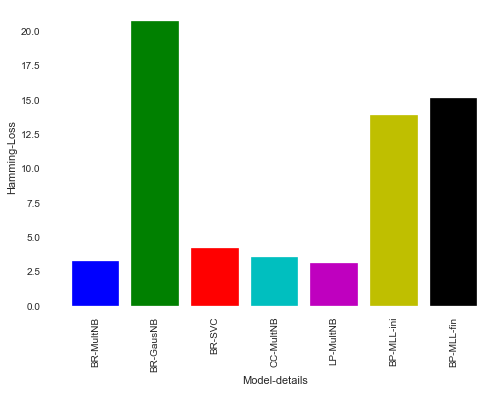

In [73]:
x = ['BR-MultNB','BR-GausNB','BR-SVC','CC-MultNB','LP-MultNB','BP-MLL-ini','BP-MLL-fin']
y = [3.27,20.74,4.26,3.56,3.17,13.96,15.158]
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.ylabel('Hamming-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

#####  •	Binary Relevance Method with SVM classifier had 4.72% hamming loss which is slightly greater than Naïve Bayes model and log loss 0.50 that makes this model better than Naïve Bayes classifier model.
#####  •	  Back Propagation Multi-label Neural Networks with parameters (batch size 32 and epochs 10). Here, hamming loss increased by 11.87% and log loss decreased by 0.39. 
#####  Thus this can be said, that the Neural Networks model has some improved performance over the Naïve Bayes model in terms of Log loss.
